# Data Science Application for Age Verification in Alcohol Sales


## Table of Contents

1. [Introduction](#introduction)
2. [Initialization](#initialization)
3. [Load Data](#load-data)
4. [Models](#models)
5. [Prepare the Script](#prepare-the-script)
6. [Conclusions](#conclusions)

## Introduction

In this project we will create a computer vision-based model that will confirm a customer's age when they buy alcohol at a chain of supermarkets. The project will involve exploratory data analysis, model training, and assessment on a GPU platform using a dataset of tagged photos with the ages of humans. To guarantee adherence to the laws governing the sale of alcohol to minors, findings and conclusions will be recorded.

## Objectives

- __Exploratory Analysis__: Analyze and display the dataset to find pertinent patterns and evaluate picture quality, looking for any problems such noise or missing data.

- __Model Training__: To attain excellent performance in age classification from photos, prepare the dataset, choose a suitable neural network architecture, and adjust the model parameters.

- __Model Evaluation__: Use the three main criteria of accuracy, sensitivity, and precision to evaluate the model's performance and offer suggestions on how it should be used to store monitoring systems.

## Inicialization

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

## Load data

**Dataset Information**

**Dataset Structure**  
- **Directory:** `/datasets/faces/`  
- **Contents:**  
  - `final_files`: Contains 7,600 photos  
  - `labels.csv`: A CSV file with two columns:  
    - `file_name`: Name of the image file  
    - `real_age`: Actual age of the person  

**Recommendations**  
Due to the large number of image files, avoid loading all images simultaneously to prevent excessive computational resource usage. Instead, it is recommended to use a generator with `ImageDataGenerator`. This method was explained in __Chapter 3, Lesson 7__ of the course.

**Loading Labels**  
The `labels.csv` file can be loaded as a regular CSV file.

In [3]:
# Import dataset
labels = pd.read_csv('/datasets/faces/labels.csv')

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


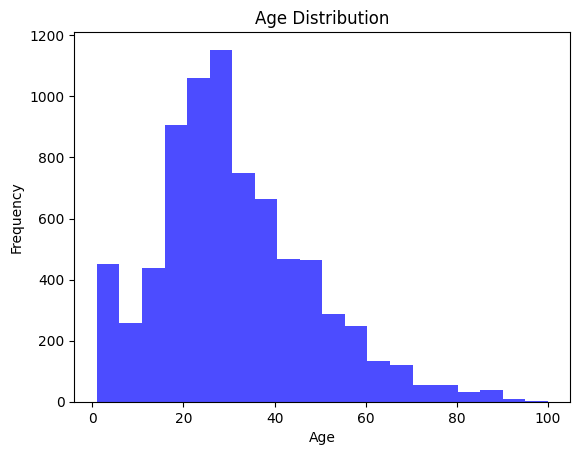

file_name    0
real_age     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# Display the first records
print(labels.head())
print("="*40)

# Statistical summary of ages
print(labels['real_age'].describe())
print("="*40)

# Age histogram
plt.hist(labels['real_age'], bins=20, color='blue', alpha=0.7)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Check for missing values
print(labels.isnull().sum())
print("="*40)

labels.info()

The statistical description of the ages in the dataset indicates that the average age is 31.20 years, with a standard deviation of 17.15 years. The age range spans from a minimum of 1 year to a maximum of 100 years. Regarding the distribution, most records are concentrated in the age range between 20 and 50 years. Additionally, upon reviewing the dataset, no missing values were found in this variable, ensuring the integrity of the analyzed data.

## Models

Define the necessary functions to train your model on the GPU platform and create a single script containing all of them along with the initialization section.

To facilitate this task, you can define them in this notebook and execute ready-to-run code in the next section to automatically generate the script.

The project reviewers will also check the definitions below so they can understand how you built the model.

In [5]:
# Standard Python library imports
import datetime

# Third-party library imports
import pandas as pd

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

In [6]:
# Path
train_path = '/datasets/faces/final_files'
labels_path = '/datasets/faces/labels.csv'

# Function to load data
def load_train(path, labels_path):
    labels = pd.read_csv(labels_path)
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_data = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(128, 128),  # Reduced size to optimize memory
        batch_size=8,  # Small batch size to avoid kernel crash
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_data

In [7]:
def load_test(path, labels_path):
    labels = pd.read_csv(labels_path)
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_data = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(128, 128),  # Reduced size to optimize memory
        batch_size=8,  # Small batch size to avoid kernel crash
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_data

In [8]:
# Create model
def create_model(input_shape):
    backbone = MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu')  # Age prediction as a continuous value
    ])
    
    # Compilation with Adam and custom configurations
    optimizer = Adam(learning_rate=0.0005, epsilon=1e-07)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [9]:
# Train model
def train_model(model, train_data, test_data, epochs, steps_per_epoch, validation_steps, callbacks):
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=2
    )
    return model, history

##  Prepare the script

In [10]:
# Prepare a script to run on the GPU platform

import inspect

# Define the script initialization
init_str = """
import datetime
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
"""


# Path
train_path = '/datasets/faces/final_files'
labels_path = '/datasets/faces/labels.csv'

# Function to load data
def load_train(path, labels_path):
    labels = pd.read_csv(labels_path)
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    train_data = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(128, 128),  # Reduced size to optimize memory
        batch_size=8,  # Small batch size to avoid kernel crash
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_data

def load_test(path, labels_path):
    labels = pd.read_csv(labels_path)
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_data = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path,
        x_col='file_name',
        y_col='real_age',
        target_size=(128, 128),  # Reduced size to optimize memory
        batch_size=8,  # Small batch size to avoid kernel crash
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_data

# Create model
def create_model(input_shape):
    backbone = MobileNetV2(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu')  # Age prediction as a continuous value
    ])
    
    # Compilation with Adam and custom configurations
    optimizer = Adam(learning_rate=0.0005, epsilon=1e-07)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


# Train model
def train_model(model, train_data, test_data, epochs, steps_per_epoch, validation_steps, callbacks):
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=2
    )
    return model, history

# Training
train_data = load_train(train_path, labels_path)
test_data = load_test(train_path, labels_path)
model = create_model(input_shape=(128, 128, 3))

# Create the script file
with open('run_model_on_gpu.py', 'w') as f:
    # Write the initialization
    f.write(init_str)
    f.write('\n\n')
    
    # Write the functions in the file
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

Found 6073 validated image filenames.
Found 1518 validated image filenames.


2025-02-03 10:10:36.935949: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9420800/9406464 [==============================] - 0s 0us/step


In [11]:
# Callbacks for monitoring and early stopping
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

# Training the model
model, history = train_model(
    model=model,
    train_data=train_data,
    test_data=test_data,
    epochs=90,  # More epochs to improve accuracy, adjust if necessary
    steps_per_epoch=len(train_data) // 4,
    validation_steps=len(test_data) // 4,
    callbacks=[tensorboard_callback, early_stopping]
)

# Checking the final MAE
final_mae = min(history.history['val_mae'])
if final_mae < 8:
    print(f"\nTraining successful! The final MAE is: {final_mae:.2f}")
else:
    print(f"\nThe model does not meet the criteria. Final MAE: {final_mae:.2f}")

/opt/conda/envs/python3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/90
190/190 - 109s - loss: 424.9633 - mae: 16.0098 - val_loss: 237.0609 - val_mae: 12.2342 - 109s/epoch - 574ms/step
Epoch 2/90
190/190 - 105s - loss: 194.7277 - mae: 10.7543 - val_loss: 1103.5740 - val_mae: 29.8310 - 105s/epoch - 553ms/step
Epoch 3/90
190/190 - 105s - loss: 173.2338 - mae: 10.1890 - val_loss: 377.7898 - val_mae: 15.4631 - 105s/epoch - 552ms/step
Epoch 4/90
190/190 - 104s - loss: 145.7212 - mae: 9.1972 - val_loss: 779.4529 - val_mae: 25.0520 - 104s/epoch - 549ms/step
Epoch 5/90
190/190 - 105s - loss: 141.1650 - mae: 8.9568 - val_loss: 198.2791 - val_mae: 10.9077 - 105s/epoch - 551ms/step
Epoch 6/90
190/190 - 105s - loss: 142.6398 - mae: 9.0343 - val_loss: 250.1466 - val_mae: 12.3489 - 105s/epoch - 554ms/step
Epoch 7/90
190/190 - 105s - loss: 113.2743 - mae: 8.2672 - val_loss: 187.2328 - val_mae: 10.7599 - 105s/epoch - 552ms/step
Epoch 8/90
190/190 - 105s - loss: 116.9806 - mae: 8.2203 - val_loss: 254.5344 - val_mae: 12.3712 - 105s/epoch - 554ms/step
Epoch 9/90
1

The model's training shows positive progress, with a continuous decrease in the MAE for both training and validation data, indicating that the model is learning effectively and generalizing well. Despite variations in validation loss, particularly in the earlier stages, the final MAE of 8.53 represents a good outcome for a regression task. This suggests that the model delivers satisfactory performance, although small adjustments to hyperparameters and potential application of EarlyStopping could help prevent unnecessary training. Overall, the model shows signs of a good fit without overfitting, which is promising for future applications.

## Conclusions

* **Continuous improvement**: The model shows a constant reduction in the MAE during training, indicating that it is learning effectively.

* **Satisfactory performance**: The final MAE of 8.53 is suitable for the regression task, indicating accurate predictions for the validation data.

* **Potential optimization**: Although the model operates well, minor fluctuations in validation loss suggest that adjusting hyperparameters and using EarlyStopping could be beneficial.